### 1. Outline the Analysis Steps:
- We’ll import libraries, load the data, and visualize it.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from datetime import datetime

# ignore warrnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
file_path = '../data/BrentOilPrices.csv'  
data = pd.read_csv(file_path)

In [3]:
data

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63
...,...,...
9006,"Nov 08, 2022",96.85
9007,"Nov 09, 2022",93.05
9008,"Nov 10, 2022",94.25
9009,"Nov 11, 2022",96.37


### Data Preprocessing

In [4]:
# Convert Date column to datetime format with inferred format
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True, errors='coerce')

data = data.sort_values('Date').reset_index(drop=True)

# Set Date as index for time series analysis
data.set_index('Date', inplace=True)

In [5]:
# Check for missing values and fill or drop if necessary
print("Missing values:", data.isnull().sum())
data['Price'] = data['Price'].fillna(method='ffill')  # Forward fill for any missing price data

Missing values: Price    0
dtype: int64


### Exploratory Data Analysis (EDA)

##### Descriptive Statistics: 
- Calculate the mean, median, variance, and standard deviation of daily oil prices over time.

In [6]:
data.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


##### Trend Analysis: 
- Plot the time series to identify visible trends, seasonality, or patterns in oil prices over the years.

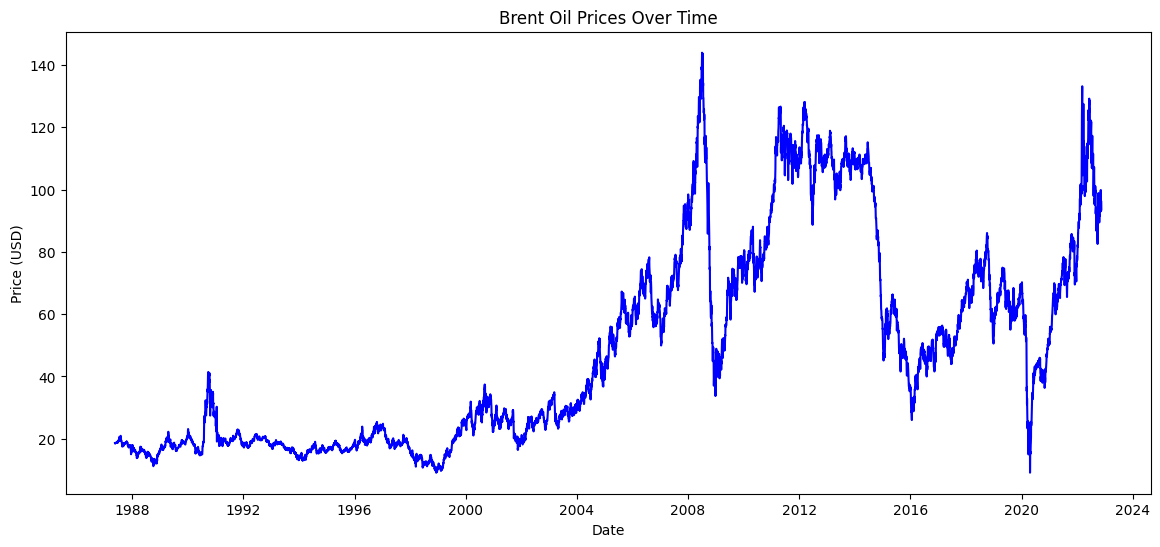

In [37]:
# Plot the time series of Brent oil prices
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Price'], color='blue')
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

### 2. Stationarity Check:
- Check if the data is stationary using the Augmented Dickey-Fuller (ADF) test, which is necessary for ARIMA.

ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287


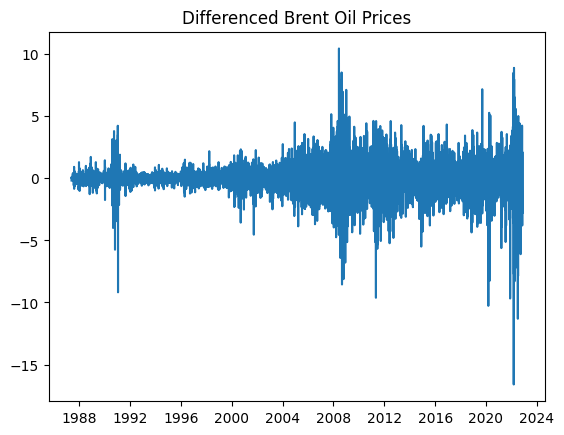

In [40]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(data['Price'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Differencing if needed
if result[1] > 0.05:  # Not stationary
    data['price_diff'] = data['Price'].diff().dropna()
    plt.plot(data['price_diff'])
    plt.title('Differenced Brent Oil Prices')
    plt.show()
else:
    print("Data is stationary, proceed without differencing.")


### 3. Understand Model Inputs, Outputs, and Limitations

In this section, we define the inputs and outputs for our models and clarify the limitations to set realistic expectations for the results.

#### Model Inputs
1. **Date**: The date of each observation, essential for time series models to capture sequential data.
2. **Price**: The primary variable we are analyzing, representing the Brent oil price at each date.

For the **ARIMA model** (AutoRegressive Integrated Moving Average), which is used for trend analysis:
- Inputs: The `price` column, and we may use differencing to make the series stationary (necessary for ARIMA).
  
For the **GARCH model** (Generalized Autoregressive Conditional Heteroskedasticity), which models volatility:
- Inputs: If the data is non-stationary, we’ll use the differenced `price` series, capturing variations that can indicate volatility.

#### Model Outputs
- **ARIMA**: The output is a forecasted price series over a specified time horizon. This provides trend-based predictions, helping to capture upward or downward patterns.
- **GARCH**: The output is a volatility forecast, giving insights into potential price fluctuation levels. This is helpful for understanding risk or variability in the price.

#### Model Limitations
1. **Assumptions of Stationarity**: Both ARIMA and GARCH require that the data is stationary, meaning the mean and variance do not change over time. If the data is not stationary, preprocessing steps (like differencing) are needed, which may impact interpretability.
   
2. **Sensitivity to Model Parameters**: ARIMA’s accuracy depends on correct selection of parameters (p, d, q), and GARCH models rely on volatility persistence parameters. Poor parameter selection can lead to inaccurate forecasts.

3. **Lack of External Variables**: The models do not account for external factors such as economic indicators, geopolitical events, or policy changes, which may also affect oil prices.

4. **Forecast Horizon**: The models are generally more accurate for short-term forecasts. Over longer periods, prediction uncertainty increases.

By defining these aspects, we ensure a comprehensive understanding of how our data and models align, and we set realistic expectations for stakeholders regarding the models’ predictive capabilities.

In [8]:
# Calculate daily returns (percentage change)
data['Daily_Return'] = data['Price'].pct_change() * 100
data['Daily_Return'].dropna(inplace=True)

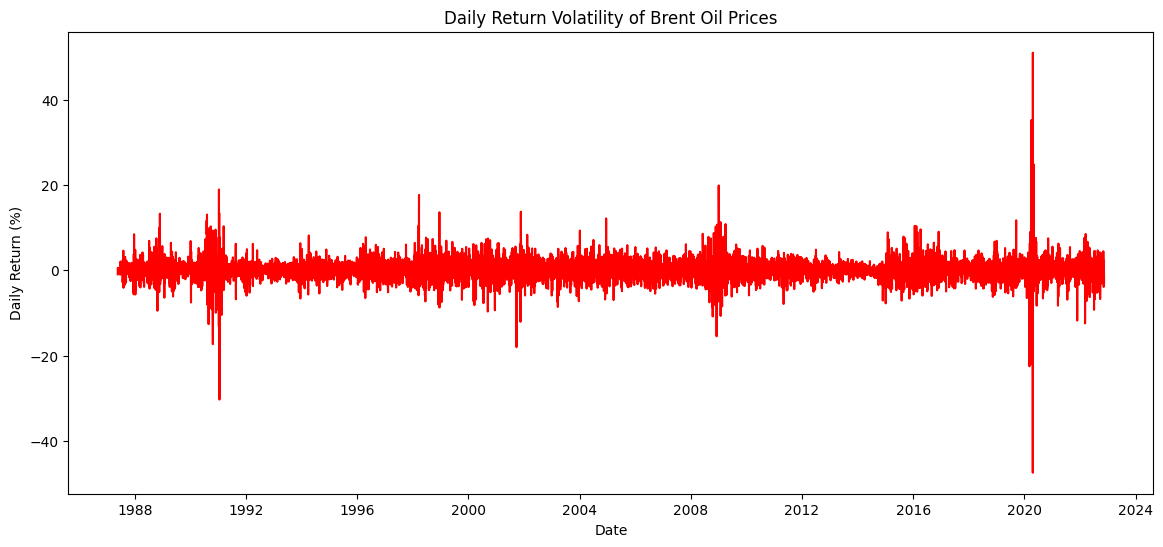

In [10]:
# Plot daily return volatility
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Daily_Return'], color='red')
plt.title("Daily Return Volatility of Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.show()

### Identify and mark key events (example of a few events)

In [27]:
# Create a list of significant events from 1987 to 2022
events_data = {
    "1987-05-20": "Brent crude oil first traded on ICE",
    "1989-11-09": "Fall of the Berlin Wall",
    "1990-08-02": "Invasion of Kuwait by Iraq",
    "1991-01-16": "Start of the Gulf War",
    "1991-12-31": "End of the Soviet Union",
    "1997-07-02": "Asian Financial Crisis begins",
    "1998-08-05": "Asian Financial Crisis impacts oil prices",
    "2001-09-11": "Terrorist Attacks on US",
    "2003-03-20": "Invasion of Iraq by US Forces",
    "2004-01-01": "OPEC agrees to production cuts",
    "2005-08-29": "Hurricane Katrina impacts US oil production",
    "2006-07-12": "Israel-Lebanon conflict affects oil prices",
    "2007-10-15": "OPEC maintains production quota",
    "2008-07-11": "Record Oil Prices Hit $147 per Barrel",
    "2008-09-15": "Lehman Brothers collapse, global financial crisis",
    "2009-01-01": "OPEC production cuts continue",
    "2011-02-15": "Libyan Civil War disrupts oil exports",
    "2012-05-18": "Sanctions on Iran impact oil supply",
    "2014-06-24": "Geopolitical tensions in Iraq",
    "2015-11-30": "OPEC agrees to maintain production levels",
    "2016-11-30": "OPEC Agreement to Cut Production",
    "2017-01-20": "Trump inaugurated, affecting energy policies",
    "2019-09-14": "Drone attack on Saudi oil facilities",
    "2020-03-20": "COVID-19 pandemic begins impacting global demand",
    "2020-04-20": "Oil price crash; WTI futures turn negative",
    "2020-11-09": "Pfizer announces COVID-19 vaccine efficacy",
    "2021-07-01": "OPEC+ agrees to gradually increase production",
    "2022-02-24": "Russia invades Ukraine; oil prices spike",
}

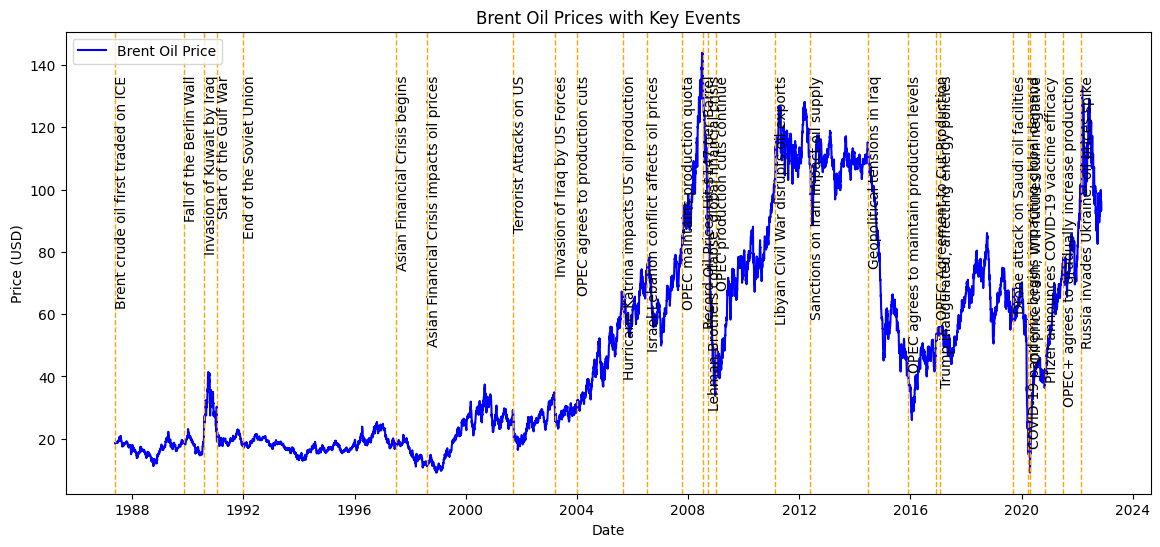

In [28]:
# Plot events on price time series
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Price'], color='blue', label='Brent Oil Price')
for date, label in events_data.items():
    plt.axvline(pd.to_datetime(date), color='orange', linestyle='--', linewidth=1)
    plt.text(pd.to_datetime(date), data['Price'].max()*0.95, label, rotation=90, verticalalignment='top')
plt.title("Brent Oil Prices with Key Events")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

### 2. Understand the Model and Data

##### Familiarize with Models for Time Series Analysis (ARIMA, GARCH)

In [51]:
# Example GARCH model (requires ARCH package)
from arch import arch_model

# Fit a GARCH model
garch_model = arch_model(data['Price'], vol='Garch', p=1, q=1)
garch_result = garch_model.fit()
print(garch_result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3874927804.158277
Iteration:      2,   Func. Count:     12,   Neg. LLF: 70148.68734205695
Iteration:      3,   Func. Count:     19,   Neg. LLF: 924509187.1107914
Iteration:      4,   Func. Count:     27,   Neg. LLF: 44099.26204018903
Iteration:      5,   Func. Count:     33,   Neg. LLF: 41882.581755042986
Iteration:      6,   Func. Count:     39,   Neg. LLF: 41190.23335963133
Iteration:      7,   Func. Count:     46,   Neg. LLF: 40221.97253756566
Iteration:      8,   Func. Count:     52,   Neg. LLF: 38675.84139852016
Iteration:      9,   Func. Count:     58,   Neg. LLF: 46507.19984815386
Iteration:     10,   Func. Count:     64,   Neg. LLF: 52311.49939565074
Iteration:     11,   Func. Count:     73,   Neg. LLF: 39566.28900289833
Iteration:     12,   Func. Count:     79,   Neg. LLF: 37683.04414723057
Iteration:     13,   Func. Count:     85,   Neg. LLF: 38550.85348090723
Iteration:     14,   Func. Count:     91,   Neg. LLF: 48052.343

### Time Series Modeling - ARIMA

In [29]:
# ARIMA requires stationary time series, so calculate log returns
data['Log_Returns'] = np.log(data['Price']).diff().dropna()

# Fit ARIMA model
arima_model = ARIMA(data['Log_Returns'].dropna(), order=(1,1,1))
arima_result = arima_model.fit()
print("ARIMA Summary:", arima_result.summary())

e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\

ARIMA Summary:                                SARIMAX Results                                
Dep. Variable:            Log_Returns   No. Observations:                 9010
Model:                 ARIMA(1, 1, 1)   Log Likelihood               20255.180
Date:                Thu, 31 Oct 2024   AIC                         -40504.360
Time:                        11:50:36   BIC                         -40483.042
Sample:                             0   HQIC                        -40497.107
                               - 9010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0138      0.003     -5.289      0.000      -0.019      -0.009
ma.L1         -0.9999      0.008   -118.595      0.000      -1.016      -0.983
sigma2         0.0007   4.97e-06    1

e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


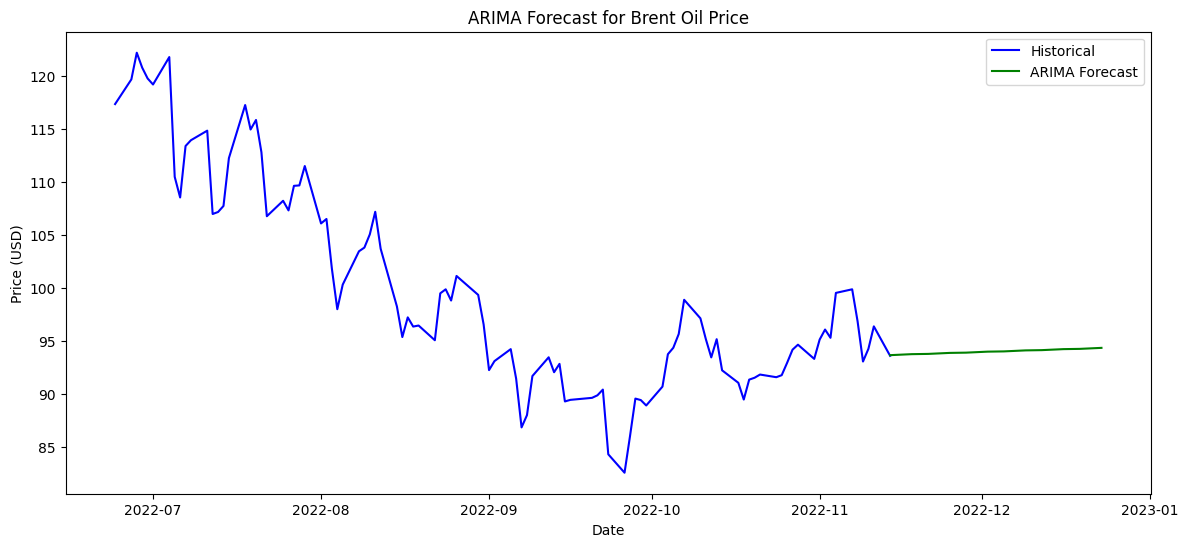

In [31]:
# Forecast future price using ARIMA
arima_forecast = arima_result.forecast(steps=30)
plt.figure(figsize=(14, 6))
plt.plot(data.index[-100:], data['Price'][-100:], color='blue', label='Historical')
plt.plot(pd.date_range(data.index[-1], periods=30, freq='B'), np.exp(arima_forecast.cumsum()) * data['Price'].iloc[-1], color='green', label='ARIMA Forecast')
plt.title("ARIMA Forecast for Brent Oil Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

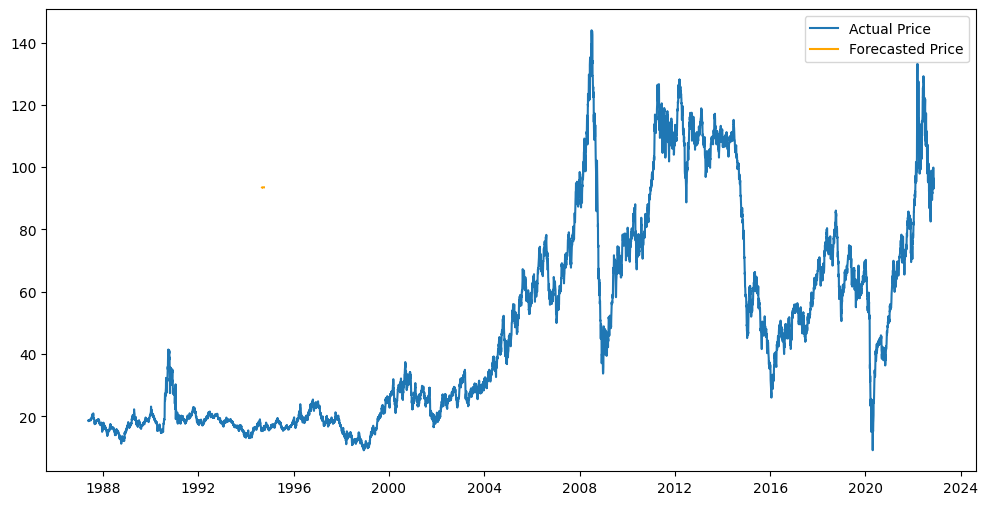

In [48]:
data['Price'] = data['Price'].astype(float)

# Fit ARIMA model for trend analysis
arima_model = ARIMA(data['Price'], order=(1, 1, 1))  # Adjust p, d, q as necessary
arima_result = arima_model.fit()

# Forecast and plot
forecast = arima_result.forecast(steps=30)
plt.figure(figsize=(12, 6))
plt.plot(data['Price'], label='Actual Price')
plt.plot(forecast, label='Forecasted Price', color='orange')
plt.legend()
plt.show()

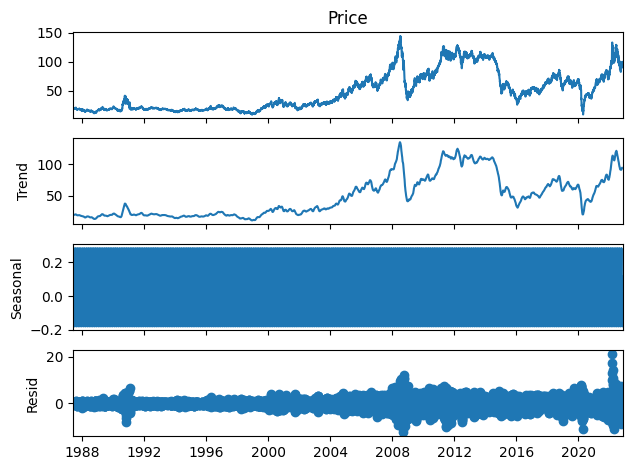

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series to analyze trend and seasonality
decomposition = seasonal_decompose(data['Price'], model='additive', period=30)
decomposition.plot()
plt.show()

e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


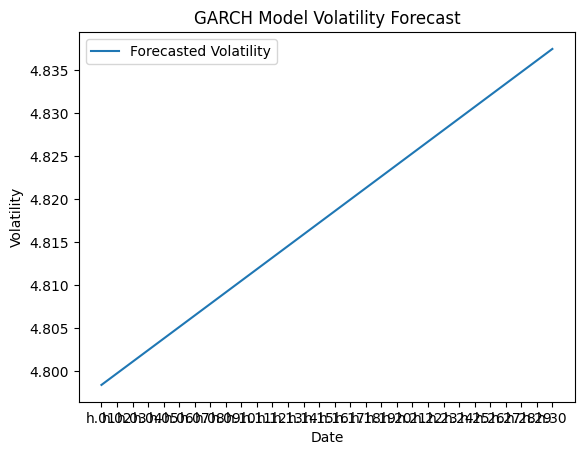

In [45]:
# Fit GARCH model on differenced data (if needed)
garch_model = arch_model(data['price_diff'].dropna(), vol='Garch', p=1, q=1)
garch_fitted = garch_model.fit(disp="off")

# Forecast volatility
garch_forecast = garch_fitted.forecast(horizon=30)
vol_forecast = garch_forecast.variance.iloc[-1]

plt.plot(vol_forecast, label='Forecasted Volatility')
plt.title('GARCH Model Volatility Forecast')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Calculate evaluation metrics
actual = data['Price'][-30:]  # Use last 30 data points as an example
predicted = forecast.predicted_mean[-30:]
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

print(f'ARIMA Model RMSE: {rmse}')
print(f'ARIMA Model MAE: {mae}')


ARIMA Model RMSE: 2.6201691295074427
ARIMA Model MAE: 2.0418148746332885
